<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1_Experiments_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [6]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [7]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [8]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [9]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [13]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [14]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [17]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [18]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [19]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [20]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

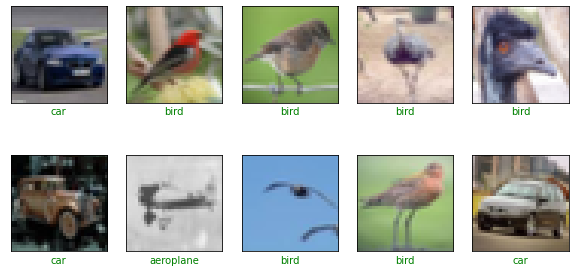

In [21]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [22]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [23]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [24]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [25]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 5: Experiment 1 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

#### Model 5.1

Same as Model 1 with regularization - Dropout (0.30)

In [26]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_1 = Sequential()
model_5_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_1.add(layers.Dense(units = 100, activation = "relu"))
model_5_1.add(Dropout(0.30))
model_5_1.add(layers.Dense(units = 150, activation = "relu"))
model_5_1.add(Dropout(0.30))
model_5_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trai

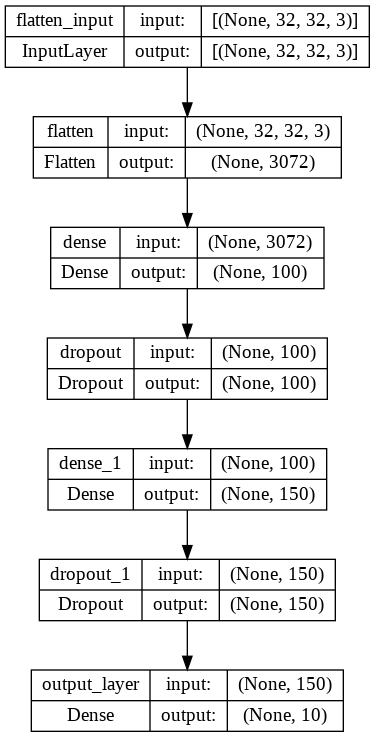

In [27]:
keras.utils.plot_model(model_5_1, "CIFAR_model.png", show_shapes=True) 

In [28]:
## Compile

model_5_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
## Train 
from time import perf_counter 
time = perf_counter()

history_5_1 = model_5_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 4ms/step - loss: 2.1309 - accuracy: 0.1826 - val_loss: 1.9929 - val_accuracy: 0.2376
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 2.0749 - accuracy: 0.2042 - val_loss: 1.9957 - val_accuracy: 0.2592
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 2.0598 - accuracy: 0.2110 - val_loss: 1.9609 - val_accuracy: 0.2834
Epoch 4/200
704/704 [==============================] - 2s 4ms/step - loss: 2.0484 - accuracy: 0.2183 - val_loss: 1.9646 - val_accuracy: 0.2798
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 2.0355 - accuracy: 0.2238 - val_loss: 1.9776 - val_accuracy: 0.2720
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 2.0301 - accuracy: 0.2279 - val_loss: 1.9749 - val_accuracy: 0.2650


In [30]:
time_5_1 = perf_counter() - time
print(time_5_1)

18.511666641000005


In [31]:
## Evaluate

model_5_1 = tf.keras.models.load_model("DNN_model_5_1.h5")
print(f"Test acc: {model_5_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.9511 - accuracy: 0.2831
Test acc: 0.283


#### Model 5.1.1

Same as Model 1 with regularization - Dropout (0.1)

In [32]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_11 = Sequential()
model_5_11.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_11.add(layers.Dense(units = 100, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(units = 150, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 150)               15150     
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-tr

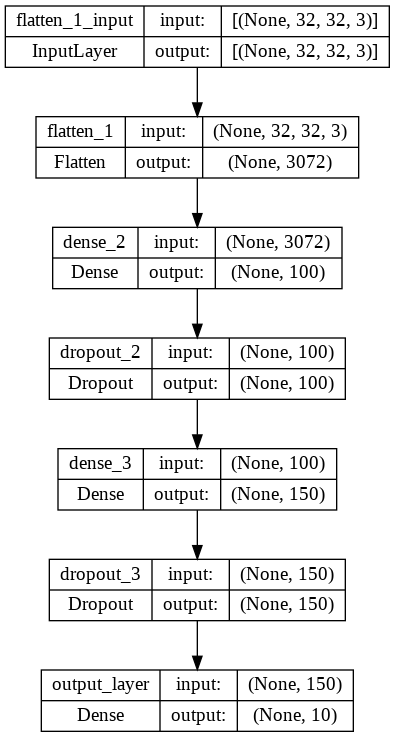

In [33]:
keras.utils.plot_model(model_5_11, "CIFAR_model.png", show_shapes=True) 

In [34]:
## Compile

model_5_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [35]:
## Train 
time = perf_counter()

history_5_11 = model_5_11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_11.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 5ms/step - loss: 1.9830 - accuracy: 0.2721 - val_loss: 1.8430 - val_accuracy: 0.3354
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8538 - accuracy: 0.3283 - val_loss: 1.7669 - val_accuracy: 0.3548
Epoch 3/200
704/704 [==============================] - 2s 4ms/step - loss: 1.8043 - accuracy: 0.3463 - val_loss: 1.7888 - val_accuracy: 0.3478
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7711 - accuracy: 0.3603 - val_loss: 1.7145 - val_accuracy: 0.3804
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7506 - accuracy: 0.3681 - val_loss: 1.7300 - val_accuracy: 0.3726
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7300 - accuracy: 0.3738 - val_loss: 1.6928 - val_accuracy: 0.3896
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7135 - accuracy: 0.3834 - val_loss: 1.6662 - val_accuracy: 0.3894

In [36]:
time_5_11 = perf_counter() - time
print(time_5_11)

42.486982246999986


In [37]:
## Evaluate

model_5_11 = tf.keras.models.load_model("DNN_model_5_11.h5")
print(f"Test acc: {model_5_11.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.5837 - accuracy: 0.4370
Test acc: 0.437


#### Model 5.1.2

Same as Model 5.1 with regularization - Dropout (0.1) new hidden nodes (550, 300)

In [38]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_12 = Sequential()
model_5_12.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_12.add(layers.Dense(units = 550, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(units = 300, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_12.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 550)               1690150   
                                                                 
 dropout_4 (Dropout)         (None, 550)               0         
                                                                 
 dense_5 (Dense)             (None, 300)               165300    
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 output_layer (Dense)        (None, 10)                3010      
                                                                 
Total params: 1,858,460
Trainable params: 1,858,460
No

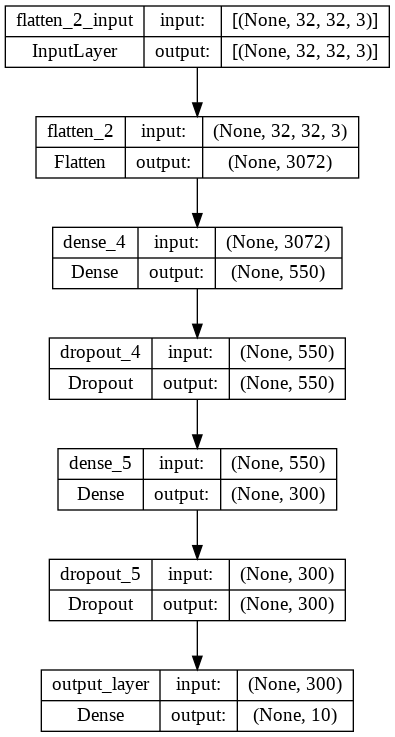

In [39]:
keras.utils.plot_model(model_5_12, "CIFAR_model.png", show_shapes=True) 

In [40]:
## Compile

model_5_12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [41]:
## Train 
time = perf_counter()

history_5_12 = model_5_12.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_12.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.9511 - accuracy: 0.2936 - val_loss: 1.7947 - val_accuracy: 0.3356
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7730 - accuracy: 0.3604 - val_loss: 1.7028 - val_accuracy: 0.3922
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6983 - accuracy: 0.3882 - val_loss: 1.7071 - val_accuracy: 0.3756
Epoch 4/200
704/704 [==============================] - 2s 4ms/step - loss: 1.6478 - accuracy: 0.4077 - val_loss: 1.6426 - val_accuracy: 0.4132
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6156 - accuracy: 0.4188 - val_loss: 1.6232 - val_accuracy: 0.4192
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5904 - accuracy: 0.4298 - val_loss: 1.5521 - val_accuracy: 0.4442
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5656 - accuracy: 0.4384 - val_loss: 1.5694 - val_accuracy: 0.4270

In [42]:
time_5_12 = perf_counter() - time
print(time_5_12)

62.075990426999994


In [43]:
## Evaluate

model_5_12 = tf.keras.models.load_model("DNN_model_5_12.h5")
print(f"Test acc: {model_5_12.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4386 - accuracy: 0.4959
Test acc: 0.496


#### Model 5.1.3 - BEST MODEL for 1

Same as Model 5.1.2 with regularization - Dropout (0.10) + added layer (250 nodes) + output activation = sigmoid

In [44]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_13 = Sequential()
model_5_13.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_13.add(layers.Dense(units = 550, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 300, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 250, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 550)               1690150   
                                                                 
 dropout_6 (Dropout)         (None, 550)               0         
                                                                 
 dense_7 (Dense)             (None, 300)               165300    
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 250)               75250     
                                                                 
 dropout_8 (Dropout)         (None, 250)              

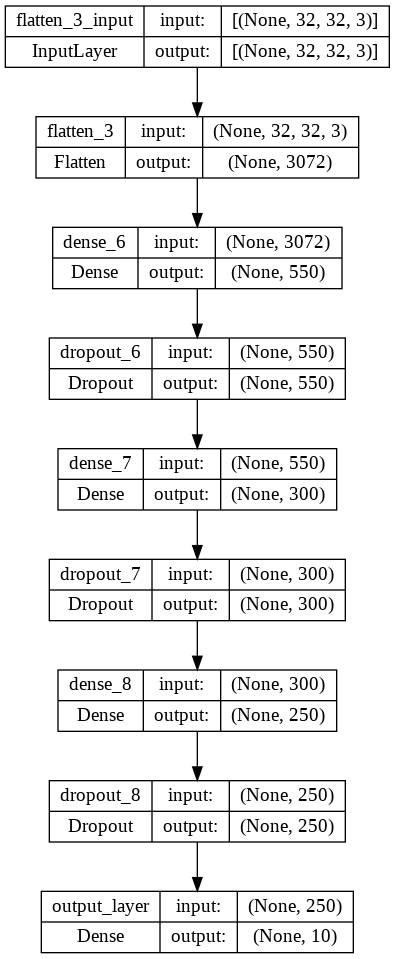

In [45]:
keras.utils.plot_model(model_5_13, "CIFAR_model.png", show_shapes=True) 

In [46]:
## Compile

model_5_13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
time = perf_counter()

history_5_13 = model_5_13.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_13.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 4s 4ms/step - loss: 1.9342 - accuracy: 0.2912 - val_loss: 1.8269 - val_accuracy: 0.3450
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7759 - accuracy: 0.3594 - val_loss: 1.7245 - val_accuracy: 0.3776
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.7159 - accuracy: 0.3834 - val_loss: 1.6632 - val_accuracy: 0.4036
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6603 - accuracy: 0.4004 - val_loss: 1.6210 - val_accuracy: 0.4196
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6349 - accuracy: 0.4095 - val_loss: 1.5824 - val_accuracy: 0.4254
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5960 - accuracy: 0.4238 - val_loss: 1.6278 - val_accuracy: 0.4050
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5830 - accuracy: 0.4304 - val_loss: 1.5897 - val_accuracy: 0.4264

In [ ]:
time_5_13 = perf_counter() - time
print(time_5_13)

In [ ]:
## Evaluate

model_5_13 = tf.keras.models.load_model("DNN_model_5_13.h5")
print(f"Test acc: {model_5_13.evaluate(x_test_norm, y_test)[1]:.3f}")